# Imports

In [1]:
import os
import json
import pickle
import tarfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

from utils import *

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Define Helper Functions

In [3]:
# define a function to save the feature vector dictionary to disk
def load_feature_data(vectors_filepath, names_filepath):
    
    # extract the JSON file from the tar.gz file
    with tarfile.open(vectors_filepath, 'r:gz') as tar:
        tar.extractall()
        json_filename = tar.getnames()[0]  # assuming only one file in the archive
    
    # load the JSON file and convert Python lists back to numpy arrays
    with open(json_filename, 'r') as f:
        feature_vectors_dict = json.load(f)
    
    feature_vectors = {}
    for class_name, vectors in feature_vectors_dict.items():
        feature_vectors[class_name] = [np.array(vector) for vector in vectors]
    
    # remove the extracted JSON file
    os.remove(json_filename)
    
    # load feature names
    with open(names_filepath, 'rb') as f:
        feature_names = pickle.load(f)
        
    return feature_vectors, feature_names

In [4]:
# define a function to visualize the PCA elbow plot
def evaluate_pca(pca):
    
    # compute the cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # plot the elbow plot
    plt.figure(figsize=(5, 3))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative % of Variation Explained')
    plt.title('Principal Component Elbow Plot')
    plt.grid(True)
    
    # find the location of inflection point
    # NOTE: this is used to determine the best number of PC's
    diff = np.diff(cumulative_variance)
    inflection_point = np.argmax(diff < np.mean(diff))
    plt.axvline(x=inflection_point + 1, color='r', linestyle='--')
    plt.axhline(y=cumulative_variance[inflection_point], color='r', linestyle='--')
    
    # add label to indicate inflection point
    plt.text(inflection_point + 50, cumulative_variance[inflection_point] - .2,
            f"n_components={inflection_point + 1}\ncum_%_variation={cumulative_variance[inflection_point]*100:.2f}%", color='r', fontsize=10)

    plt.show()
    
    return inflection_point + 1
    

In [5]:
# define a function to display the main features that contribute to a set of top PC's
def display_loadings(pca, n_pc=5, n_features=10):
    
    # extract top principal components
    top_components = pca.components_[:n_pc]

    # create dataframes for top principal components
    for i, component in enumerate(top_components):
        loading_scores = pd.DataFrame({'feature_name': feature_names, 'loading_score': component})
        loading_scores = loading_scores.sort_values(by='loading_score', ascending=False).head(n_features)
        print(f"Top {n_features} features for Principal Component {i + 1}:")
        display(loading_scores)

# Load data

In [6]:
# define file directory
directory = '../data/interim/PatternNet/PatternNet/images'

# create a list of classes considered for this project
classes = ['beach', 'chaparral', 'dense_residential', 'forest', 'freeway', 'harbor', 'overpass', 'parking_space', 'river', 'swimming_pool']

In [7]:
# load feature data from disk
feature_vectors_train, feature_names = load_feature_data("../data/processed/feature_vectors_train.tar.gz", "../data/processed/feature_names.pkl")
feature_vectors_val, feature_names = load_feature_data("../data/processed/feature_vectors_val.tar.gz", "../data/processed/feature_names.pkl")
feature_vectors_test, feature_names = load_feature_data("../data/processed/feature_vectors_test.tar.gz", "../data/processed/feature_names.pkl")


In [8]:
# inspections
print(type(feature_vectors_train))
print(feature_vectors_train.keys())
print(type(feature_vectors_train['beach']))
print(len(feature_vectors_train['beach']))
print(type(feature_vectors_train['beach'][0]))
print(len(feature_vectors_train['beach'][0]))
print(feature_vectors_train['beach'][0])

<class 'dict'>
dict_keys(['parking_space', 'beach', 'forest', 'overpass', 'river', 'dense_residential', 'swimming_pool', 'chaparral', 'freeway', 'harbor'])
<class 'list'>
479
<class 'numpy.ndarray'>
1412
[113.95576477 127.46353149 119.84751892 ...  22.           1.
   5.        ]


# Transform data

In [9]:
# flatten feature vectors and prepare data for PCA
X = []
for class_name in classes:
    X.extend(feature_vectors_train[class_name])
X = np.array(X)
print(X.shape)

# standardize data
features_scaler = StandardScaler()
X = features_scaler.fit_transform(X)

# save the standardization scaler to disk
with open("../data/processed/features_scaler.pkl", 'wb') as f:
    pickle.dump(features_scaler, f)

(4799, 1412)


# Principal Component Analysis

In [10]:
# perform PCA
pca_model = PCA()
pca_model.fit(X)

PCA()

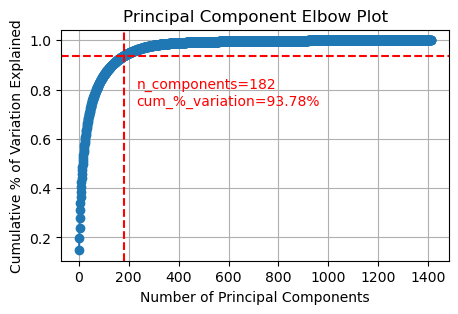

In [11]:
n_pc_components = evaluate_pca(pca_model)

In [12]:
display_loadings(pca_model, n_pc=20, n_features=5)

Top 5 features for Principal Component 1:


,feature_name,loading_score
1272,hog_1206,0.039247
1056,hog_990,0.038968
1236,hog_1170,0.038045
1260,hog_1194,0.038043
1240,hog_1174,0.037787


Top 5 features for Principal Component 2:


,feature_name,loading_score
662,hog_596,0.061744
1365,energy_mean,0.059531
674,hog_608,0.057512
878,hog_812,0.057380
866,hog_800,0.056013


Top 5 features for Principal Component 3:


,feature_name,loading_score
186,hog_120,0.049345
390,hog_324,0.048643
819,hog_753,0.048167
1023,hog_957,0.047129
634,hog_568,0.045109


Top 5 features for Principal Component 4:


,feature_name,loading_score
1364,homogeneity_mean,0.065435
821,hog_755,0.057855
856,hog_790,0.053338
857,hog_791,0.053152
1366,correlation_mean,0.053084


Top 5 features for Principal Component 5:


,feature_name,loading_score
785,hog_719,0.065345
849,hog_783,0.064482
393,hog_327,0.064230
884,hog_818,0.064069
784,hog_718,0.063387


Top 5 features for Principal Component 6:


,feature_name,loading_score
27,s_2,0.064159
1364,homogeneity_mean,0.063150
26,s_1,0.048450
1399,sift_bow_7,0.047553
1366,correlation_mean,0.047493


Top 5 features for Principal Component 7:


,feature_name,loading_score
362,hog_296,0.081819
578,hog_512,0.077795
646,hog_580,0.073245
398,hog_332,0.072225
778,hog_712,0.071974


Top 5 features for Principal Component 8:


,feature_name,loading_score
605,hog_539,0.072257
602,hog_536,0.070312
637,hog_571,0.068205
598,hog_532,0.066160
603,hog_537,0.065274


Top 5 features for Principal Component 9:


,feature_name,loading_score
779,hog_713,0.077498
747,hog_681,0.076524
983,hog_917,0.070751
951,hog_885,0.070062
811,hog_745,0.069169


Top 5 features for Principal Component 10:


,feature_name,loading_score
511,hog_445,0.073799
307,hog_241,0.072209
727,hog_661,0.072056
523,hog_457,0.072011
295,hog_229,0.070122


Top 5 features for Principal Component 11:


,feature_name,loading_score
1184,hog_1118,0.081179
1183,hog_1117,0.076908
980,hog_914,0.071475
1185,hog_1119,0.068598
1182,hog_1116,0.065986


Top 5 features for Principal Component 12:


,feature_name,loading_score
708,hog_642,0.085915
912,hog_846,0.084358
676,hog_610,0.078565
880,hog_814,0.078110
712,hog_646,0.073945


Top 5 features for Principal Component 13:


,feature_name,loading_score
1137,hog_1071,0.078154
1134,hog_1068,0.072155
1341,hog_1275,0.070814
1136,hog_1070,0.070055
164,hog_98,0.064739


Top 5 features for Principal Component 14:


,feature_name,loading_score
1386,freqbin_19,0.082577
1387,freqbin_20,0.076527
1330,hog_1264,0.075298
1185,hog_1119,0.074446
1298,hog_1232,0.074385


Top 5 features for Principal Component 15:


,feature_name,loading_score
75,hog_9,0.077027
76,hog_10,0.070957
292,hog_226,0.067222
526,hog_460,0.066633
529,hog_463,0.065299


Top 5 features for Principal Component 16:


,feature_name,loading_score
651,hog_585,0.074302
683,hog_617,0.068394
447,hog_381,0.063844
652,hog_586,0.063563
435,hog_369,0.061434


Top 5 features for Principal Component 17:


,feature_name,loading_score
427,hog_361,0.067451
395,hog_329,0.066655
972,hog_906,0.065920
363,hog_297,0.065119
564,hog_498,0.064895


Top 5 features for Principal Component 18:


,feature_name,loading_score
2,b_mean,0.084217
58,v_13,0.081693
0,r_mean,0.080655
3,r_std,0.077878
1407,sift_bow_15,0.077344


Top 5 features for Principal Component 19:


,feature_name,loading_score
129,hog_63,0.083386
333,hog_267,0.079585
537,hog_471,0.078962
97,hog_31,0.078918
721,hog_655,0.074956


Top 5 features for Principal Component 20:


,feature_name,loading_score
196,hog_130,0.082681
195,hog_129,0.081506
400,hog_334,0.080113
399,hog_333,0.078833
432,hog_366,0.077813


In [13]:
# re-compute pca model with optimum number of PC's
pca_model = PCA(n_components=n_pc_components)
pca_model.fit(X)

# save the pca model to disk
with open("../data/processed/pca_model.pkl", 'wb') as f:
    pickle.dump(pca_model, f)

# tSNE Visualization

In [14]:
# load class color map from pickle file
with open('../data/processed/eda_class_color_mapping.pkl', 'rb') as f:
    class_color_mapping= pickle.load(f)

In [15]:
# compress data based on PCA model
pc_vectors_train = pca_model.transform(X)

# initialize tSNE with desired parameters
tsne = TSNE(n_components=2)

# fit and transform the data using t-SNE
tsne_data = tsne.fit_transform(pc_vectors_train)

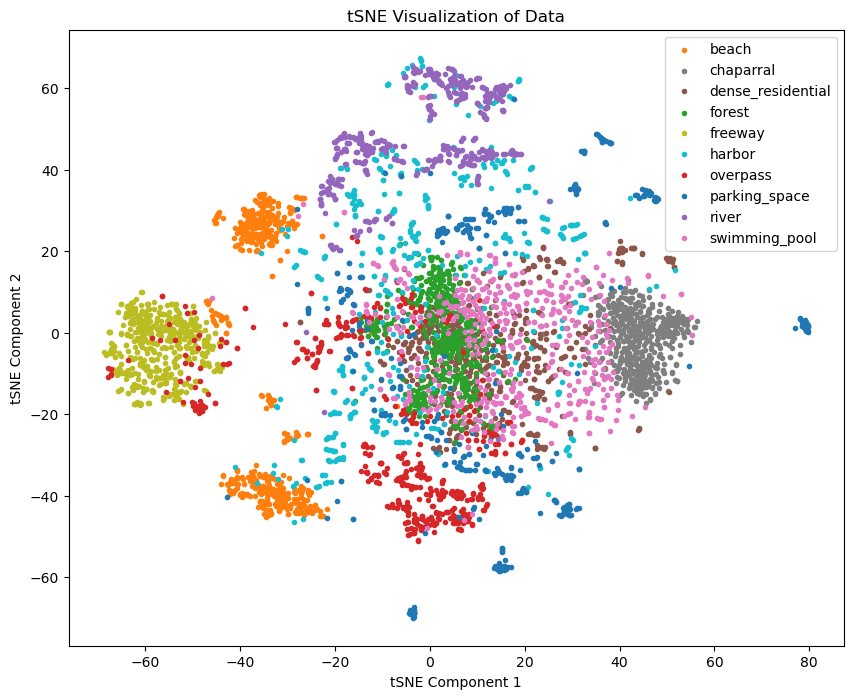

In [16]:
# visualize clustering of train pc's with color-coded classes using loaded class color mapping
plt.figure(figsize=(10, 8))
start_idx = 0
for class_name in classes:
    end_idx = start_idx + len(feature_vectors_train[class_name])
    class_color = class_color_mapping[class_name]
    plt.scatter(tsne_data[start_idx:end_idx, 0], tsne_data[start_idx:end_idx, 1], marker='.', color=class_color, label=class_name)
    start_idx = end_idx
plt.title('tSNE Visualization of Data')
plt.xlabel('tSNE Component 1')
plt.ylabel('tSNE Component 2')
plt.legend()
plt.show()
